<a href="https://colab.research.google.com/github/Yuanranzhu/SINN/blob/main/Double_well_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!hostname

e5ea29e7eccd


In [2]:
!nvidia-smi

Mon Sep 19 18:23:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install torch sdeint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sdeint: filename=sdeint-0.3.0-py3-none-any.whl size=25907 sha256=0e6c0258cf547b110dd5c9a793624e7de378e0ff44e0240ed019264f9d237a38
  Stored in directory: /root/.cache/pip/wheels/64/30/eb/70e285284253db9252d1dcdc6cea14cc860d95e7ed201efd9d
Successfully built sdeint


In [4]:
# check out SINN model from repo
!git clone https://github.com/SINN-model/SINN.git
!cp SINN/toolbox . -r

Cloning into 'SINN'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 26 (delta 8), reused 12 (delta 4), pack-reused 0
Unpacking objects: 100% (26/26), done.


In [5]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)

In [6]:
device = torch.device('cuda')

320.0


(800, 400) (800, 400)


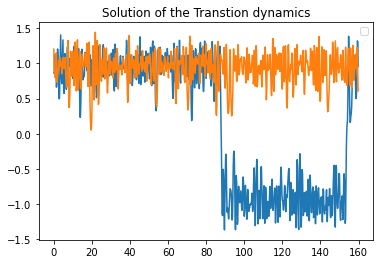

<Figure size 432x288 with 0 Axes>

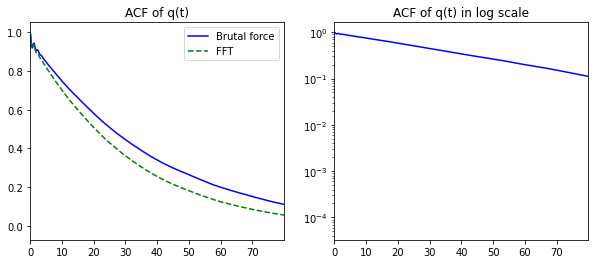

(400, 400) (400, 400)
CPU times: user 36.3 s, sys: 221 ms, total: 36.5 s
Wall time: 41.2 s


In [7]:
%%time

#### Generating SINN training data by solving the Langevin dynamics for the double-potential well

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad

def V_FPU(x,U0,x0,sigma):
    v=U0/x0**4*x**3+U0/x0**2*x      # FPU potential 
    return v

def V_double_well(x,U0,x0,sigma):
    v=4*U0/x0**4*x**3-4*U0/x0**2*x+sigma/(2*x0)         # Double-well potential 
    return v 

def integrand(x,U0,x0,beta,sigma):
    v=np.exp(-beta*(U0*(1-(x/x0)**2)**2+sigma*x/(2*x0)))        # integrand function
    return v 

def integrand2(x,U0,x0,beta,sigma):
    v=x**2*np.exp(-beta*(U0*(1-(x/x0)**2)**2+sigma*x/(2*x0)))        # integrand function
    return v 

######## Paraemters 
gamma=1                   # Coupling constant 
beta=1                    # Inverse temperature, i.e. T=1/beta
U0=4                      # Depth of the well 
x0=1                      # Basin of the well
sigma=0                   # Asymmetry of the well 
dt=0.001                  # Step-size of the SDE solver 
delta_t=0.2               # Step-size of the temporally coarse-grained path
batch = 400               # Batch size 
sec_length = 400          # Length of the input sequence 
I=quad(integrand,-10,10,args=(U0,x0,beta,sigma))
I2=quad(integrand2,-10,10,args=(U0,x0,beta,sigma))   # PDF normalization constant (partition function) 

### SDE solver (EM scheme), 
Time = 4*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]
p_store = np.zeros([t_store.size+1,batch])
q_store = np.zeros([t_store.size+1,batch])
p=np.zeros((2,batch))
q=np.zeros((2,batch))
# solve SDE
j=1
for i in range(1,length):
     q[1,:] = q[0,:] + p[0,:]*dt
     p[1,:] = p[0,:] + (-V_double_well(q[0,:],U0,x0,sigma)-gamma*p[0,:])*dt + np.random.randn(1,batch)*np.sqrt(2*dt*gamma/beta)
     if i % gap ==0:            
            p_store[j,:]=p[1,:]
            q_store[j,:]=q[1,:]
            j=j+1
     p[0,:]=p[1,:]
     q[0,:]=q[1,:]

Toss=int(t_store.size/2)
p_store=p_store[Toss:-1,:]          
q_store=q_store[Toss:-1,:]         
print(p_store.shape,q_store.shape)




plt.figure(1)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,i])
plt.legend()
plt.title("Solution of the Transtion dynamics")


## Calculating the acf for q(t) by brutal force
Traj1=q_store
T_acf=t_store[0:Traj1.shape[0]]
acf_u=StatLoss.acf(torch.from_numpy(Traj1.reshape(Traj1.shape[0], batch,1)),method='bruteforce')
acf_u_fft=StatLoss.acf(torch.from_numpy(Traj1.reshape(Traj1.shape[0], batch,1)))
corr_u=acf_u.mean(axis=1).detach().cpu().numpy()
corr_u_fft=acf_u_fft.mean(axis=1).detach().cpu().numpy()
plt.figure(2)      
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(T_acf, corr_u,'b',label='Brutal force')
axs[0].plot(T_acf, corr_u_fft,'g--',label='FFT')
axs[0].set_title('ACF of q(t)')
axs[0].set_xlim([0,T_acf[-1]/2])
axs[0].legend()
axs[1].semilogy(T_acf, corr_u,'b')
axs[1].semilogy(T_acf, np.zeros([Traj1.shape[0],1]),'r')
axs[1].set_title('ACF of q(t) in log scale')
axs[1].set_xlim([0,T_acf[-1]/2])
plt.show()


#####################  Construct the sample traj for SINN learning 
ini=np.random.randn(sec_length,batch)
Traj=q_store[0:sec_length,:]
T=np.arange(len(Traj[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
pdf_exact=np.exp(-beta*(U0*(1-(x/x0)**2)**2+sigma*x/(2*x0)))/I[0]
print(ini.shape, Traj.shape)




In [8]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 1), device=device)

# input of the LSTM should be of the form (seq_len, batch, input_size)
Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch,1)).to(device)
PDF_exact=torch.from_numpy(pdf_exact).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 1]) torch.float32
The torch validation size is torch.Size([800, 400, 1]) torch.float32
The torch target size is torch.Size([400, 400, 1]) torch.float32


In [9]:
# Defining Loss functions

LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_q2 = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)
loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, device=device)
loss_pdf_exact = make_loss('pdf', PDF_exact, lower=-5, upper=5, n=N, device=device)

/content/toolbox/_loss.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._target = torch.tensor(target, dtype=torch.float32, device=device)


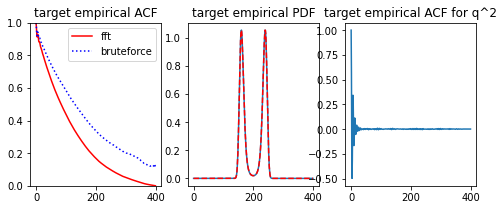

In [10]:
# Plotting target ACFs and PDF

fig, axs = plt.subplots(1, 3, figsize=(8, 3))
axs[0].plot(loss_acf_fft._target.cpu(),'r', label='fft')
axs[0].plot(loss_acf_bruteforce._target.cpu(),'b:', label='bruteforce')
axs[0].set_title('target empirical ACF')
axs[0].set_ylim([0,1])
axs[1].plot(loss_pdf_exact._target.cpu())
x_grid=-np.linspace(-5,5,num=sec_length)
axs[1].plot(np.exp(-beta*(U0*(1-(x_grid/x0)**2)**2+sigma*x_grid/(2*x0)))/I[0],'r--')
axs[1].set_title('target empirical PDF')
axs[2].plot(loss_acf_q2._target.cpu())
axs[2].set_title('target empirical ACF for q^2')
axs[0].legend()
plt.show()

In [25]:
### Defining SINN model
net = SINN(1, 25, 2, 1).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [27]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.582, 0.582
[50]-th step loss: 0.495, 0.484
[100]-th step loss: 0.195, 0.192
[150]-th step loss: 0.317, 0.307
[200]-th step loss: 0.270, 0.268
[250]-th step loss: 0.165, 0.175
[300]-th step loss: 0.318, 0.296
[350]-th step loss: 0.120, 0.119
[400]-th step loss: 0.121, 0.117
[450]-th step loss: 0.116, 0.140
[500]-th step loss: 0.106, 0.126
[550]-th step loss: 0.228, 0.217
[600]-th step loss: 0.193, 0.198
[650]-th step loss: 0.239, 0.237
[700]-th step loss: 0.173, 0.185
[750]-th step loss: 0.389, 0.382
[800]-th step loss: 0.263, 0.260
[850]-th step loss: 0.257, 0.257
[900]-th step loss: 0.253, 0.255
[950]-th step loss: 0.250, 0.252
[1000]-th step loss: 0.246, 0.249
[1050]-th step loss: 0.247, 0.240
[1100]-th step loss: 0.268, 0.273
[1150]-th step loss: 0.251, 0.253
[1200]-th step loss: 0.248, 0.248
[1250]-th step loss: 0.248, 0.244
[1300]-th step loss: 0.243, 0.240
[1350]-th step loss: 0.239, 0.237
[1400]-th step loss: 0.237, 0.234
[1450]-th step loss: 0.232, 0.230
[15

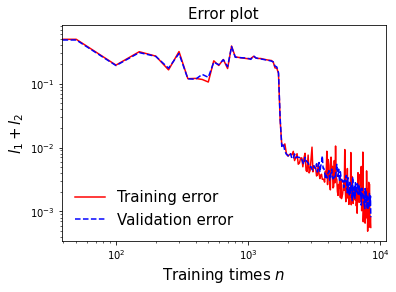

In [28]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/double_well_training_error.pdf", dpi=150)


In [29]:
# # Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch)

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 <a list of 7 Text major ticklabel objects>)

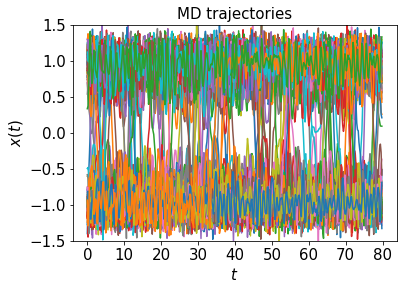

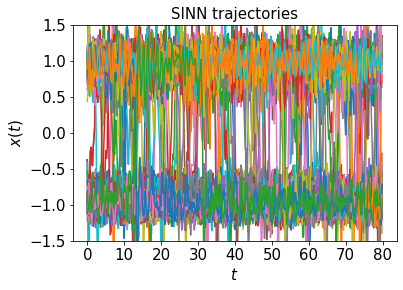

In [30]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
plt.plot(T[skip:]-T[skip], Traj[skip:, 2])
for i in range(100):
    plt.plot(T[skip:]-T[skip], Traj[skip:, i])   
plt.ylim([-1.5,1.5])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$x(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)     
# plt.savefig("figs/double_well_MD_traj_multi.pdf", dpi=150)


fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.plot(T[skip:]-T[skip], prediction[skip:, 1])
plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
for i in range(100):
    plt.plot(T[skip:]-T[skip], prediction[skip:, i])
plt.ylim([-1.5,1.5])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$x(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/double_well_traj_multi.pdf", dpi=150)



400 torch.Size([800, 400, 1]) 400 400


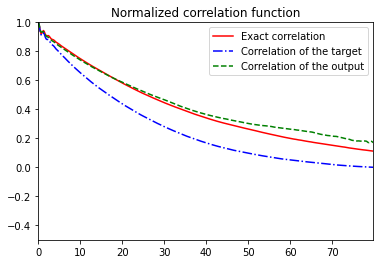

In [31]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF  

acf_p=StatLoss.acf(Pred[-sec_length:,:,:],method='bruteforce')
acf_t=StatLoss.acf(target)
corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
corr_t=acf_t.mean(axis=1).detach().cpu().numpy()

plt.figure(1)
plt.title("Normalized correlation function")    
plt.plot(T_acf, corr_u,'r',label='Exact correlation')               # Exact correlation function 
print(T.size, ran_input.size(), corr_t.size, corr_p.size)
plt.plot(T, corr_t,'b-.',label='Correlation of the target')         # Correlation function of the target 
plt.plot(T, corr_p, 'g--',label='Correlation of the output')        # Correlation function after the training 
plt.ylim(-0.5,1)
plt.xlim(0,T[-1])
plt.legend()


tensor([0.8647, 0.8776, 1.0684, 1.1233, 1.0478])
tensor([0.1857, 0.5535, 0.4840, 0.6475, 0.5456])


(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ]),
 <a list of 9 Text major ticklabel objects>)

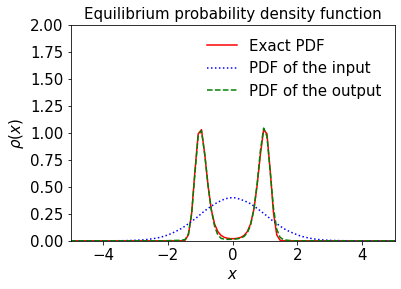

In [32]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
rho_data =  StatLoss.gauss_kde(target, -5, 5, 100).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100).cpu()
print(target.detach().cpu()[0:5,0,0])
print(Pred.detach().cpu()[0:5,0,0])

x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Equilibrium probability density function",fontsize=15)    
# plt.plot(x, rho_data.numpy(), 'r',label='PDF of the target')    # target PDF
plt.plot(x, np.exp(-beta*(U0*(1-(x/x0)**2)**2+sigma*x/(2*x0)))/I[0], 'r',label='Exact PDF') 
plt.plot(x, rho_input.numpy(), 'b:', label='PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy(), 'g--',label='PDF of the output')  # PDF after the training 
plt.xlim(-5,5)
plt.ylim(0,2)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/double_well_pdf.pdf", dpi=150)



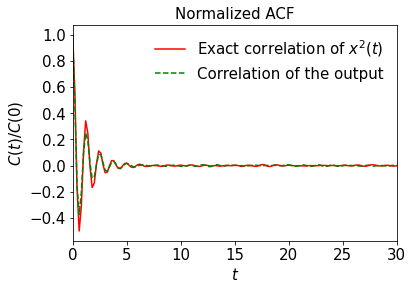

In [33]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $x^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/double_well_acf2.pdf", dpi=150)




1600.0
(4000,) (4000, 100)


(array([   0.,  200.,  400.,  600.,  800., 1000.]),
 <a list of 6 Text major ticklabel objects>)

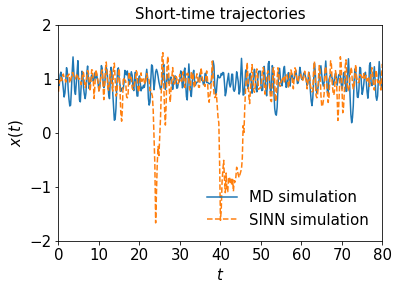

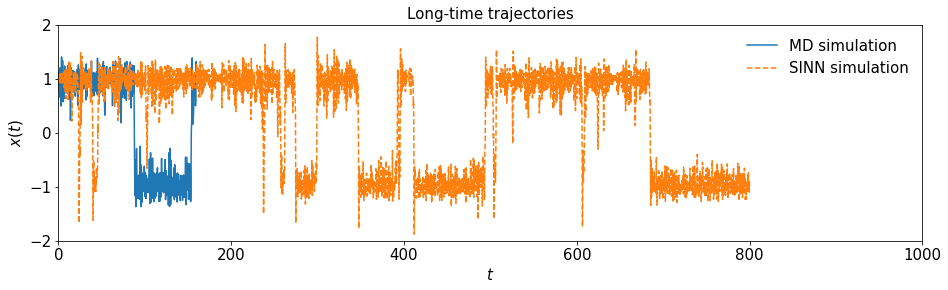

In [34]:
# Test 5: plot the expolation result, i.e. Prediction of the double-well Langevin dynamics for longer time 
[a,b,c]=input.size()
scale=10
burnin=5
fold=20
batch_new=100
print(scale*a*delta_t)
ran_input=torch.randn((scale*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape(scale*a, batch_new)
prediction_ext=prediction_ext[burnin*a:,:]
acf_p=StatLoss.acf(Pred_L[burnin*a:,:,:],method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]
print(LT.shape,prediction_ext.shape)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT, prediction_ext[:, 0],'--',label='SINN simulation')
plt.xlim([0,80])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$x(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/double_well_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT, prediction_ext[:, 0],'--',label='SINN simulation')
plt.xlim([0,1000])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$x(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/double_well_traj_lT.pdf", dpi=150)

